#### Overview
The idea was to compare an OLS model with various generic machine learning(ML) algorithms. The ML models chosen were as follows: Extra trees regressor(5),gradient boosting regressor(9,10,11,12,13) a random forest regressor(1) and an epsilon-support vector regression(2). 

The dataset contained Australian wage and unemployment rates from 1998 to 2018. Data was split into Quarterly samples as follows, training(1998-2009) and test(2010-2018). 

The independent variable or target was current period wages and the independent variables or predictors used were standardised measures of wages and unemployment lagged by one period.

The OLS model with robust standard errors was compared to several off-the-shelf machine learning(ML) regression algorithms. The results are listed below. OLS did better than the various tree based algorithms but the support vector regressor performed best on the unseen test data. I cited below two research papers on the use of HAC corrections in linear regression OLS models(14,17). 

Of the two key hyperparameters for the support vector regressor epsilon was adjusted to 0.2 and C was left at the default level of 1.0. Outside of this notebook pushing the epsilon or insensitivity zone higher than 0.2 to 0.5 significantly reduced the R2 on the test data. See Smola et. al, (1998) on the importance of selecting the right value of epsilon given the noisiness of training data(16). To paraphrase the authors of the paper, '... there exists a linear dependency between the level of the additive noise in the target values Y and the size of epsilon'.(16)
 
Footnotes:
Variable selection for the OLS model was based on an attempt to violate as few of the main OLS assumptions as possible. There was minimal tweaking of any hyperparameters across the various ML algorithms. It is noted that as the OLS model exists below, Econometricians would likely view the regression as spurious(6,14). 


#### References
1. Breiman L (2001). "Random Forests". Machine Learning. 45 (1): 5–32.
2. Cortes, Corinna; Vapnik, Vladimir N. (1995). "Support-vector networks". Machine Learning. 20 (3): 273–297.  
3. Friedman, J. H. (February 1999). Greedy Function Approximation: A Gradient Boosting Machine, IMS 1999 Reitz lecture.
4. Friedman, J. H. (March 1999). "Stochastic Gradient Boosting" .
5. Geurts P, Ernst,D · Wehenkel, L (2006), Extremely randomized trees, Department of Electrical Engineering and Computer Science, University of Liege,
6. Granger, C. W. J., and Newbold P.(2014). Spurious Regressions in Econometrics. Journal of Econometrics (July 1974): 11 l-20. 
7. Ho,T,K (1995). Random Decision Forests. Proceedings of the 3rd International Conference on Document Analysis and Recognition, Montreal, QC, 14–16 August 1995. pp. 278–282.  
8. KECMAN, V., 2001. Learning and soft computing. MIT Press Cambridge, Mass.  
9. Kleinberg E (1990)."Stochastic Discrimination. Annals of Mathematics and Artificial Intelligence. 1 (1–4): 207–239.  
10. Kleinberg E (1996). An Overtraining-Resistant Stochastic Modeling Method for Pattern Recognition. Annals of Statistics. 24 (6): 2319–2349. 
11. Kleinberg E (2000). "On the Algorithmic Implementation of Stochastic Discrimination" (PDF). IEEE Transactions on PAMI. 22 (5): 473–490.  
12. Mason, L.; Baxter, J.; Bartlett, P. L.; Frean, Marcus (1999). Boosting Algorithms as Gradient Descent. In S.A. Solla and T.K. Leen and K. Müller. Advances in Neural Information Processing Systems 12. MIT Press. pp. 512–518.
13. Mason, L., Baxter, J., Bartlett, P. L., Frean, Marcus (May 1999). Boosting Algorithms as Gradient Descent in Function Space. NIPS Proceedings.
14. MULLER U K,(2014). HAC Corrections for Strongly Autocorrelated,Time Series,Department of Economics, Princeton University, Princeton, NJ 08544
15. Phillips, P. C. B.(1986). Understanding Spurious Regressions in Econometrics. Joumal of Econometrics 33 (1986): 3 1 l-40. 
16. SMOLA, A.,Murata, N, Scholkopfyz,B (1998). Asymptotically optimal choice of ε–loss for support vector machines, Proceedings of the International Conference on Artificial Neural Networks, pp. 105-110, Springer, Berlin.
17. Zeileis, A (2004). Econometric Computing with HC and HAC,Covariance Matrix Estimators,Journal of Statistical Software 

In [1]:
#Dependencies. 
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat
#Numpy
import numpy as np
from numpy import array
#Plot dependencies
import matplotlib.pyplot as plt
from matplotlib import pyplot
#Sklearn 
from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVR
#Scipy and statsmodel 
import scipy as sp
from scipy import stats
from scipy import interp 
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

In [2]:
#Functions

#Read in data and prepare for testing.
def prepare_data():   
    #Read in data
    data = pd.read_csv('/Users/brianfarrell/Desktop/data.csv',index_col='Time')    
    #Create lags
    dataframe = concat([data.shift(1),data], axis=1)
    dataframe.columns = ['U_t_1','W_t_1','U_t','W_t']
    dat=dataframe.iloc[1:,]    
    #Define train and test data sets    
    #Training data
    global x_train,y_train,y_train_1
    d_train=dat.iloc[0:45,]
    y_train=pd.DataFrame(d_train['W_t'])
    x_train=d_train.drop(['W_t'],axis=1)     
    #Assert 1d shape of y vector for machine learning algorithms
    y_train_1= np.asarray(y_train).reshape(45,)     
    #Scale features.The standard score of a sample x is calculated as: z = (x - u) / s  u=mean , s=std dev   
    scaler = StandardScaler()
    x_train['U_t_1_s']= scaler.fit_transform((x_train['U_t_1']).values.reshape(-1,1))
    x_train['W_t_1_s']= scaler.fit_transform((x_train['W_t_1']).values.reshape(-1,1))
    global train
    train= pd.concat([x_train,y_train],axis=1,join_axes=[x_train.index])         
    #Test data
    d_test=dat.iloc[45:,]
    global x_test,y_test,y_test_1
    y_test= d_test['W_t']   
    x_test=d_test.drop(['W_t'],axis=1)    
    #Assert 1d shape of y_test vector for machine learning algorithms
    y_test_1= np.asarray(y_test).reshape(33,)                      
    #Scale features test data     
    x_test['U_t_1_s']= scaler.transform((x_test['U_t_1']).values.reshape(-1,1)) 
    x_test['W_t_1_s']= scaler.transform((x_test['W_t_1']).values.reshape(-1,1))
    global test 
    test= pd.concat([x_test,y_test],axis=1,join_axes=[x_test.index])

    #Plot train and test scatter plots
    fig, axs = plt.subplots(1, 2, figsize=(15, 3), sharey=True)
    axs[0].scatter(d_train['U_t'],d_train['W_t'],label="training data")
    axs[1].scatter(d_test['U_t'],d_test['W_t'],label="test data")
    axs[0].set_ylabel('Wages')
    axs[0].set_xlabel('Unemployment')
    axs[0].set_title('Training data',fontsize=10)
    axs[1].set_xlabel('Unemployment')
    axs[1].set_ylabel('Wages')
    axs[1].set_title('Test data',fontsize=10)
    fig.suptitle('Unemployment(t) Vs Wages(t)',fontsize=12)
    plt.show()
    
def run_ols():     
    print("Dependent variable: Wages(t)")
    print("Independent variables(Standardised): Unemployment(t-1) and Wages(t-1)")     
    print("")
    #Running model with robust errors as autocorrelation is present  
    #Using Barlett kernel 
    global results
    results = smf.ols('W_t ~ + U_t_1_s  + W_t_1_s ' , data=train).fit(cov_type='HAC',cov_kwds={'maxlags':4})      
    #Check if errors are spherical
    #Plot residuals
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_partregress_grid(results, fig=fig)     
    print('Mean of residuals; %f' % (np.mean(results.resid)))    
    res_norm= stats.jarque_bera(results.resid)
    print('Jarque-Bera(P-Value) : %f' % (res_norm[1]))
    bp = statsmodels.stats.diagnostic.het_breuschpagan(results.resid, results.model.exog) 
    print('Breusche-Pagen(P-Value) : %f' % (bp[1]))
    bp_1 = statsmodels.stats.diagnostic.acorr_breusch_godfrey(results, nlags=4, store=False)
    print('Breushe-Godfrey(4 lags)(P-Value) : %f' % (bp_1[1]))
    if bp[1] or bp_1[1] < 0.05:
        print("Errors are not spherical,use HAC SE’s(Bartlet Kernel)") 
    print("")
    #Create VIF for Multicollinearity check.        
    X_VIF= train.loc[:,['U_t_1_s','W_t_1_s' ]] 
    VIF =  [statsmodels.stats.outliers_influence.variance_inflation_factor(X_VIF.values, i) for i in range(X_VIF.shape[1])]              
    print("Multicollinearity check: VIF scores", VIF)
    print("")
    print(results.summary())
    
def test_ols():    
    #Produce R2 on test data from the model
    predictions= results.predict(x_test)
    RSS= np.sum((np.subtract(y_test,predictions))**2)
    y_test_mean = np.mean(y_test)
    SS = np.sum((np.subtract(y_test,y_test_mean))**2)
    R_squ_test = (1 - (RSS/SS))
    print ('OLS(HAC) R2(test data) %f:' %(R_squ_test))
     
    
def test_machine_learning_algorithms():
    #Extra Trees Regressor
    et=ExtraTreesRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, 
                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                           max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                           bootstrap=False, oob_score=False, n_jobs=None, random_state=None, 
                           verbose=0, warm_start=False) 
    et.fit(x_train, y_train_1)
    print('Extra Trees Regressor R2(test data): %f ' % (et.score(x_test, y_test_1)))            
    #Gradient Boosting Regressor
    gb= ensemble.GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, 
                          subsample=0.5, criterion='friedman_mse', min_samples_split=10, 
                          min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_depth=2, 
                          min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, 
                          max_features=2, alpha=0.9, verbose=0, max_leaf_nodes=5, 
                          warm_start=False, presort='auto')

    gb.fit(x_train,y_train_1)
    print ('Gradient Boost Regressor R2(test data): %f' % (gb.score(x_test,y_test_1)))            
    #Random Forest Regressor 
    rf=RandomForestRegressor(n_estimators=100, criterion='mse', 
                             max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                             max_features='auto', max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, min_impurity_split=None, 
                             bootstrap=False,oob_score=False, n_jobs=None, 
                             random_state=None, verbose=0, warm_start=False)
    rf.fit(x_train, y_train_1)
    print('Random Forest Regressor R2(test data): %f ' % (rf.score(x_test, y_test_1)))            
                                                                                          
    #Support Vector Regressor                                           
    sv = SVR(kernel='linear',epsilon=0.2)
    sv.fit(x_train, y_train_1) 
    print('Support Vector Regressor R2(test data): %f' % (sv.score(x_test, y_test_1)))     
     

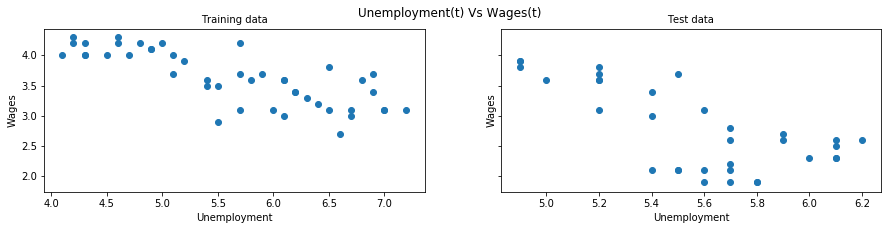

In [3]:
#This function reads in and prepares the data for analysis.
prepare_data()

Dependent variable: Wages(t)
Independent variables(Standardised): Unemployment(t-1) and Wages(t-1)

Mean of residuals; -0.000000
Jarque-Bera(P-Value) : 0.045347
Breusche-Pagen(P-Value) : 0.857762
Breushe-Godfrey(4 lags)(P-Value) : 0.001295
Errors are not spherical,use HAC SE’s(Bartlet Kernel)

Multicollinearity check: VIF scores [2.79497839235985, 2.79497839235985]

                            OLS Regression Results                            
Dep. Variable:                    W_t   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     252.3
Date:                Wed, 06 Mar 2019   Prob (F-statistic):           3.96e-24
Time:                        14:36:24   Log-Likelihood:                 14.437
No. Observations:                  45   AIC:                            -22.87
Df Residuals:                      42   BIC:                            -17.45

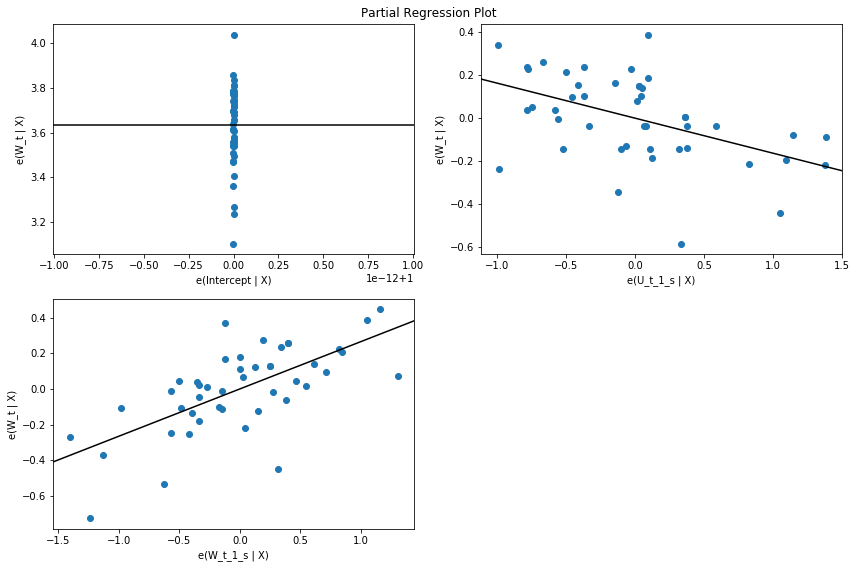

In [4]:
#This function runs an OLS model and produces relevant tests
#to see what model assumptios are possibly violated.
run_ols()

In [5]:
#Test OlS with robust standard errors on test data.
test_ols() 

OLS(HAC) R2(test data) 0.587108:


In [6]:
#Test multiple off-the-shelf machine learning regressors on test data.
test_machine_learning_algorithms()

Extra Trees Regressor R2(test data): 0.193846 
Gradient Boost Regressor R2(test data): 0.195759
Random Forest Regressor R2(test data): 0.237409 
Support Vector Regressor R2(test data): 0.877656
